In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import preprocessing
from itertools import cycle
from itertools import chain
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive

In [3]:
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [4]:
pd.options.display.float_format = '{:.1f}'.format
sns.set()
plt.style.use('ggplot')
print('Keras Version', keras.__version__)

LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
TIME_PERIOD = 80
WINDOW = 40
# originally used to fine tune the values, but that is now being done in a loop with several different dimension sizes.
tuner = 1

Keras Version 2.3.0-tf


In [0]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)

    df['z-axis'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0,how='any',inplace=True)

    return df

In [0]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [0]:

def show_basic_dataframe(dataframe):
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i' % (dataframe.shape[0]))

In [0]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15,10), sharex=True)

    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [0]:
def plot_axis(ax,x,y,title):
    ax.plot(x,y,'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y)-np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203


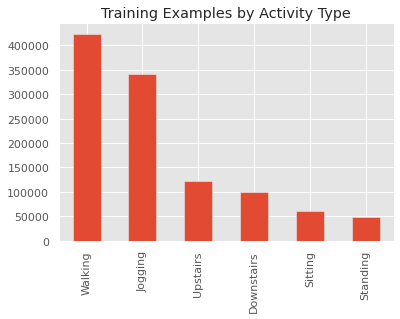

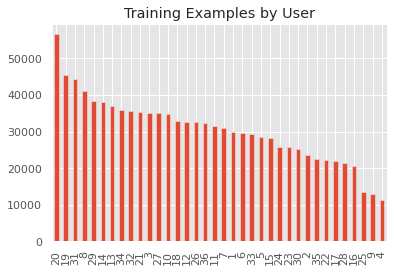

In [10]:
df = read_data('drive/My Drive/Data/WISDM_ar_v1.1_raw.txt')
show_basic_dataframe(df)
df.head(20)

df['activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()

df['user-id'].value_counts().plot(kind='bar',title='Training Examples by User')
plt.show()


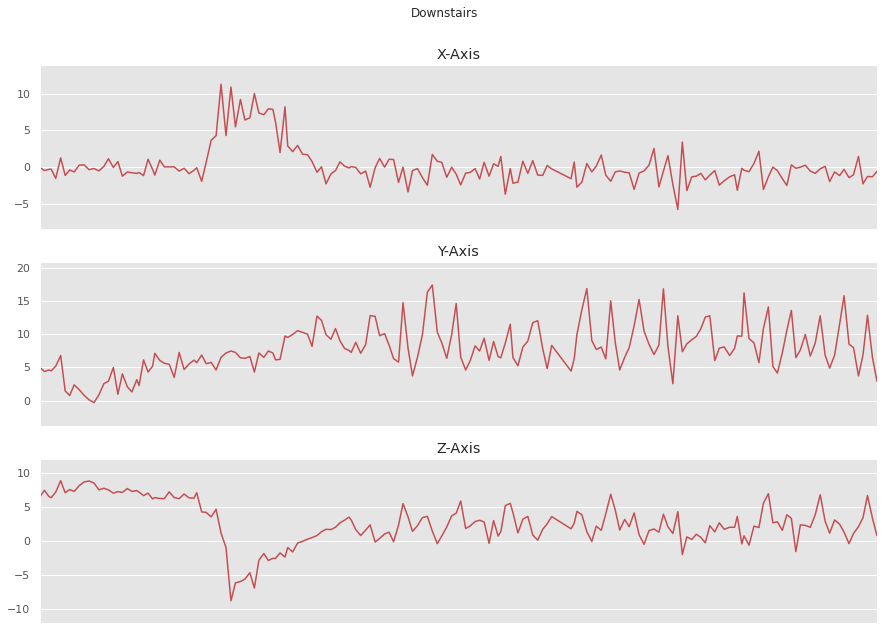

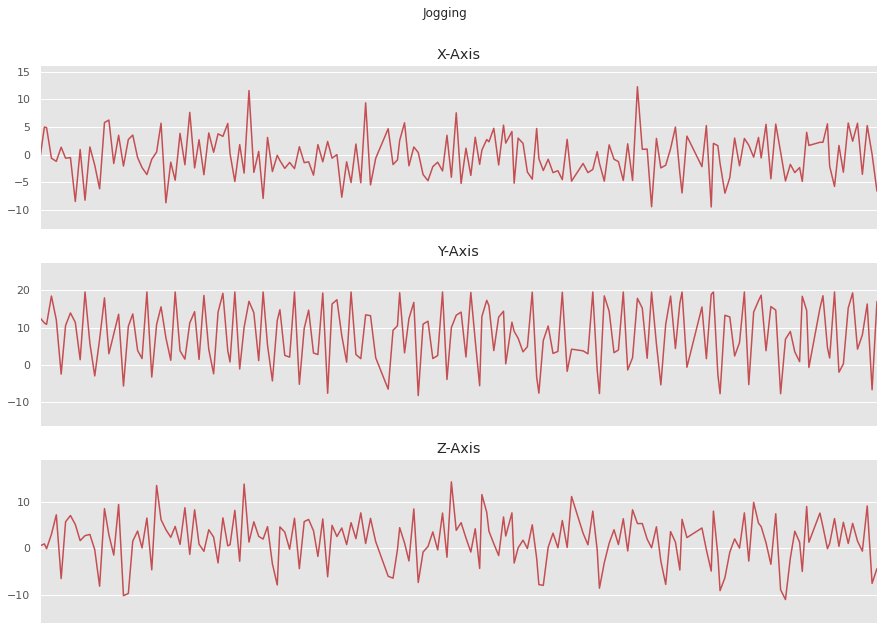

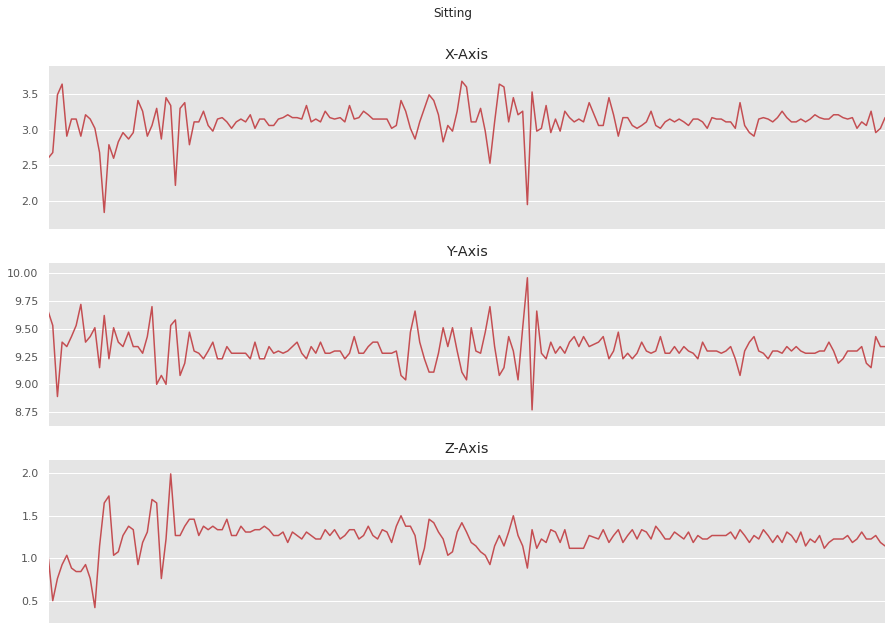

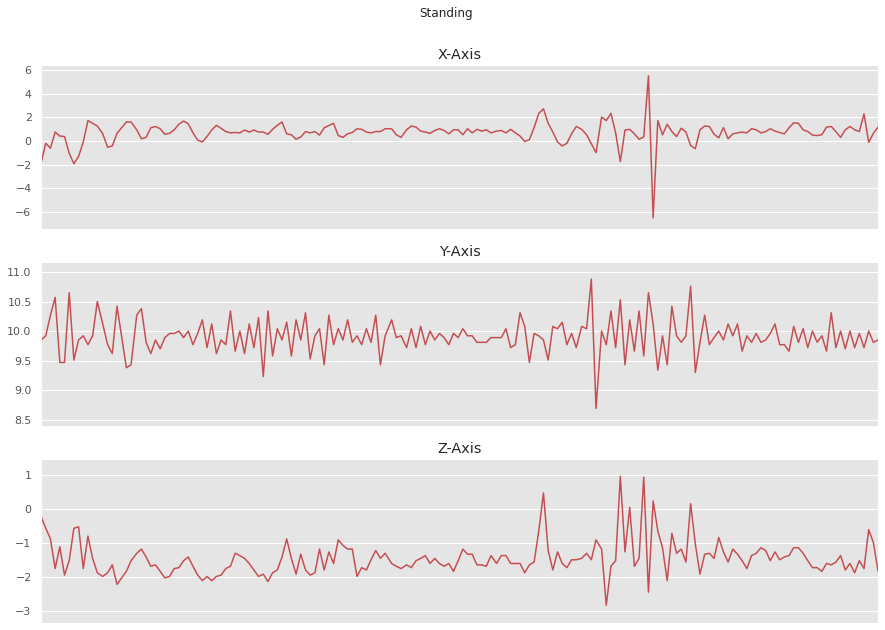

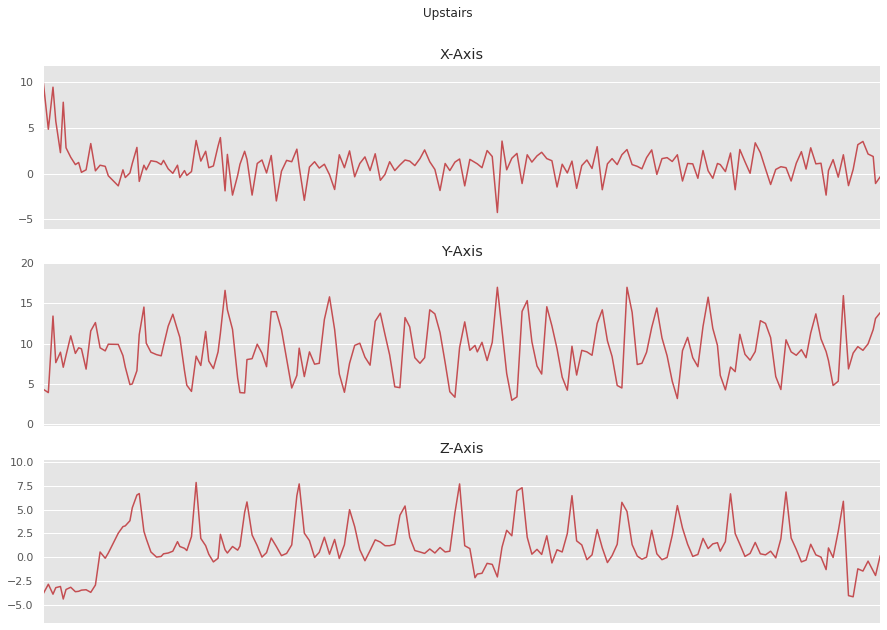

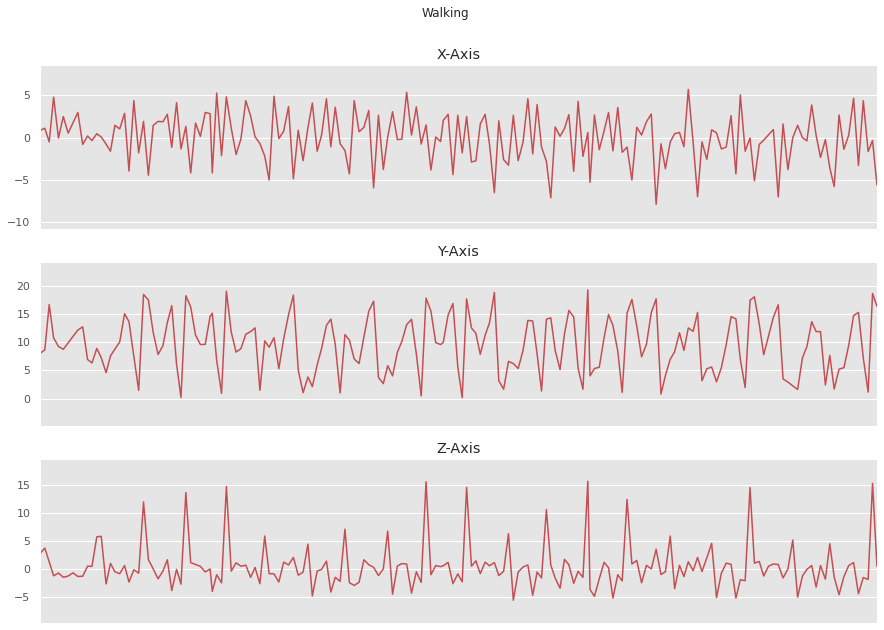

In [11]:
for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity,subset)

LABEL = 'ActivityEncoded'
le = preprocessing.LabelEncoder()

df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [0]:
def create_segments_and_labels(df, time_steps, step, label_names):
    FEATURES = 3

    segments = []
    labels = []

    for i in range(0,len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        label = stats.mode(df[label_names][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [13]:
    # Separate based of user id.
df_test = df[df['user-id'] > 28 ]
df_train = df[df['user-id'] <= 28 ]
df_train = df

pd.options.mode.chained_assignment = None
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_train = df_train.round({'x-axis': 4, 'y-axis':4, 'z-axis': 4})

X_train, y_train = create_segments_and_labels(df_train, TIME_PERIOD, WINDOW, LABEL)

print('X_train Shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
input_shape = (80*3)
x_train = X_train.reshape(X_train.shape[0], input_shape)
# print('x_train shape:', x_train)
print('input_shape:', input_shape)
samps, secs, accel = X_train.shape
red_dim = secs * accel

xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0, stratify = y_train)
xx_trainn, xx_val,yy_trainn, yy_val = train_test_split(xx_train, yy_train, test_size = 0.2, random_state = 0, stratify = yy_train)
print(xx_trainn.shape)
print(xx_val.shape)
X2_train = xx_train
X2_test = xx_test
xx_trainn = xx_trainn.reshape(len(xx_trainn),80,3)
xx_val = xx_val.reshape(len(xx_val),80,3)
xx_test = xx_test.reshape(len(xx_test),80,3)



X_train Shape: (27454, 80, 3)
27454 training samples
y_train shape:  (27454,)
input_shape: 240
(17570, 240)
(4393, 240)


In [0]:
df1=df[['x-axis','y-axis','z-axis']].head

In [15]:
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(num_time_periods, num_sensors)
print(list(le.classes_))

80 3
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [16]:
from keras.utils import np_utils
# print(yhat.shape)
y_train_hot = np_utils.to_categorical(yy_trainn, num_classes)
print('New y_train shape: ', y_train_hot.shape)
y_test_hot = np_utils.to_categorical(yy_test, num_classes)
print('New y_train shape: ', y_test_hot.shape)
y_val_hot = np_utils.to_categorical(yy_val, num_classes)
print('New y_train shape: ', y_val_hot.shape)

New y_train shape:  (17570, 6)
New y_train shape:  (5491, 6)
New y_train shape:  (4393, 6)


Using TensorFlow backend.


In [0]:

# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

In [18]:
xx_train.shape

(21963, 240)

In [19]:
model = Sequential()
model.add(LSTM(32, activation='relu',input_shape=(80,3), return_sequences=True))
model.add(TimeDistributed(Dense(3)))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80, 32)            4608      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 80, 3)             99        
Total params: 4,707
Trainable params: 4,707
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit model
auto_out=model.fit(xx_trainn, xx_trainn, epochs=100,validation_data=(xx_val,xx_val) ,batch_size=256)


Train on 17570 samples, validate on 4393 samples
Epoch 1/100
17570/17570 [==============================] - 11s 617us/step - loss: 0.0969 - accuracy: 0.4018 - val_loss: 0.0630 - val_accuracy: 0.4501
Epoch 2/100
17570/17570 [==============================] - 9s 516us/step - loss: 0.0527 - accuracy: 0.5407 - val_loss: 0.0409 - val_accuracy: 0.5897
Epoch 3/100
17570/17570 [==============================] - 9s 538us/step - loss: 0.0295 - accuracy: 0.6444 - val_loss: 0.0175 - val_accuracy: 0.7017
Epoch 4/100
17570/17570 [==============================] - 9s 534us/step - loss: 0.0122 - accuracy: 0.7446 - val_loss: 0.0085 - val_accuracy: 0.7765
Epoch 5/100
17570/17570 [==============================] - 9s 513us/step - loss: 0.0063 - accuracy: 0.8057 - val_loss: 0.0043 - val_accuracy: 0.8347
Epoch 6/100
17570/17570 [==============================] - 9s 516us/step - loss: 0.0033 - accuracy: 0.8612 - val_loss: 0.0026 - val_accuracy: 0.8788
Epoch 7/100
17570/17570 [==============================]

In [0]:
# # demonstrate reconstruction
x_en_train= model.predict(xx_trainn, verbose=3)
x_en_val= model.predict(xx_val, verbose=3)
x_en_test= model.predict(xx_test, verbose=3)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


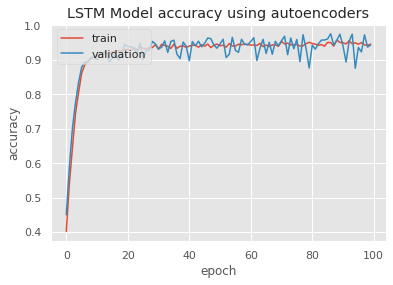

In [22]:
print(auto_out.history.keys())
# summarize history for accuracy
plt.plot(auto_out.history['accuracy'])
plt.plot(auto_out.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('LSTM Model accuracy using autoencoders')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [23]:
from keras import regularizers
model = Sequential()
model.add(LSTM(64,return_sequences=True,activation='elu', input_shape=(80,3)))

model.add(LSTM(32,activation='elu',kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(6, activation='softmax'))


model.compile(optimizer='adam' , loss='categorical_crossentropy' ,metrics=['accuracy'])

out = model.fit(x_en_train, y_train_hot,batch_size=256,epochs=30,validation_data=(x_en_val,y_val_hot))

Train on 17570 samples, validate on 4393 samples
Epoch 1/30
17570/17570 [==============================] - 19s 1ms/step - loss: 2.0994 - accuracy: 0.4116 - val_loss: 1.8710 - val_accuracy: 0.4311
Epoch 2/30
17570/17570 [==============================] - 19s 1ms/step - loss: 1.6781 - accuracy: 0.5385 - val_loss: 1.5736 - val_accuracy: 0.5573
Epoch 3/30
17570/17570 [==============================] - 19s 1ms/step - loss: 1.5174 - accuracy: 0.5791 - val_loss: 1.4574 - val_accuracy: 0.5973
Epoch 4/30
17570/17570 [==============================] - 19s 1ms/step - loss: 1.4181 - accuracy: 0.5999 - val_loss: 1.3836 - val_accuracy: 0.6271
Epoch 5/30
17570/17570 [==============================] - 19s 1ms/step - loss: 1.3366 - accuracy: 0.6233 - val_loss: 1.3077 - val_accuracy: 0.6340
Epoch 6/30
17570/17570 [==============================] - 19s 1ms/step - loss: 1.2721 - accuracy: 0.6448 - val_loss: 1.2171 - val_accuracy: 0.6631
Epoch 7/30
17570/17570 [==============================] - 19s 1ms/ste

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


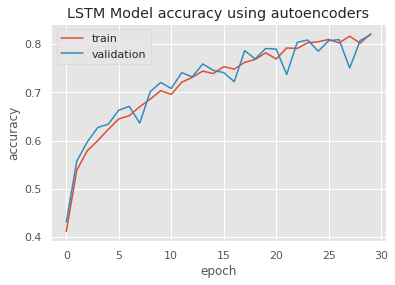

In [24]:
print(out.history.keys())
# summarize history for accuracy
plt.plot(out.history['accuracy'])
plt.plot(out.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('LSTM Model accuracy using autoencoders')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [0]:
# x_en_test= model.predict(, verbose=3)

In [26]:
model.evaluate(x_en_test,y_test_hot)

5491/5491 [==============================] - 4s 750us/step


[0.531539097300776, 0.8315425515174866]

In [0]:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [0]:

x_en_train = x_en_train.reshape(len(x_en_train), 80, 3, 1)
x_en_test = x_en_test.reshape(len(x_en_test), 80, 3, 1)
x_en_val = x_en_val.reshape(len(x_en_val), 80, 3, 1)

In [0]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = x_en_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [0]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [37]:
history = model.fit(x_en_train, yy_trainn, epochs = 30, validation_data= (x_en_val, yy_val), verbose=1)


Epoch 1/30
550/550 [==============================] - 2s 3ms/step - loss: 0.7299 - accuracy: 0.7502 - val_loss: 0.5010 - val_accuracy: 0.8234
Epoch 2/30
550/550 [==============================] - 2s 3ms/step - loss: 0.5271 - accuracy: 0.8164 - val_loss: 0.4644 - val_accuracy: 0.8379
Epoch 3/30
550/550 [==============================] - 2s 3ms/step - loss: 0.4698 - accuracy: 0.8330 - val_loss: 0.4240 - val_accuracy: 0.8420
Epoch 4/30
550/550 [==============================] - 2s 3ms/step - loss: 0.4420 - accuracy: 0.8383 - val_loss: 0.3845 - val_accuracy: 0.8520
Epoch 5/30
550/550 [==============================] - 2s 3ms/step - loss: 0.4044 - accuracy: 0.8511 - val_loss: 0.3604 - val_accuracy: 0.8623
Epoch 6/30
550/550 [==============================] - 2s 3ms/step - loss: 0.3757 - accuracy: 0.8606 - val_loss: 0.3408 - val_accuracy: 0.8675
Epoch 7/30
550/550 [==============================] - 2s 3ms/step - loss: 0.3497 - accuracy: 0.8703 - val_loss: 0.3223 - val_accuracy: 0.8755
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


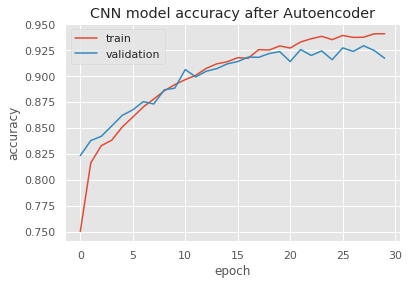

In [38]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['val_acc'])

plt.title('CNN model accuracy after Autoencoder')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [39]:
test_result = model.evaluate(x_en_test,yy_test)

172/172 [==============================] - 0s 2ms/step - loss: 0.2461 - accuracy: 0.9272


In [41]:
print("Test Accuracy: ", test_result[1])
print("Test Loss: ",test_result[0])

Test Accuracy:  0.9271535277366638
Test Loss:  0.24606609344482422
